* **Following pytorch model has one linear layer with `inputs`: 3 and `outputs`:1**

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

def create_model():
    class network(nn.Module):
        def __init__(self):
            super(network, self).__init__()
            self.fc1 = nn.Linear(3, 1)#100)

        def forward(self, X):
            X = self.fc1(X)#F.linear(self.fc1(X))#, list(self.fc1.parameters())[0])
            return X
    model= network()
    optimizer = optim.Adam(model.parameters())
    criterion= nn.MSELoss()# CrossEntropyLoss()
    return model, optimizer, criterion

In [2]:
model2, optimizer2, loss2= create_model()
model2

network(
  (fc1): Linear(in_features=3, out_features=1, bias=True)
)

* **Data preparation scheme:**

        - Each record `X` cosist of first 3 values of 4 values
          from iris dataset input features.
        
        - 4th value serve as taget label `y` .

In [3]:
def scale(arr):
    f= lambda x: (x-np.mean(x))/np.var(x)
    for idx in range(arr.shape[1]):
        arr[:,idx]= f(arr[:, idx])
    #return arr
def plot(v1):
    plt.plot(v1)
    #plt.plot(v2)
    plt.title('Model training loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    #plt.legend(['train', 'validation'], loc='upper right')
    return plt.show()

* **Training & plots**

epoch:  0  loss:  2.2136988639831543
epoch:  500  loss:  0.35722896456718445
epoch:  1000  loss:  0.27405551075935364
epoch:  1500  loss:  0.2487815022468567
epoch:  2000  loss:  0.22110269963741302


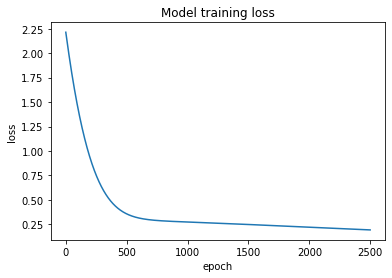

In [4]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
data = load_iris()
X, Y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.3)
scale(X)
scale(X_test)

trainx= Variable(torch.Tensor(X[:,:-1]).float(), requires_grad=True) #df.iloc[:, :-1].values).float()
trainy = Variable(torch.reshape(torch.Tensor(X[:,-1]).float(), (-1,1)))

#i_grads= np.empty(trainx.shape)
wts_bias_progression= list()
all_grads= list()
losses= list()
for epoch in range(2500):
    optimizer2.zero_grad()
    y_pred = model2(trainx)
    #print(y_pred)
    l = loss2(y_pred, trainy)
    losses.append(l.item())
    if epoch%500==0:
        print('epoch: ', epoch, ' loss: ', l.item());
    # perform a backward pass (backpropagation)
    l.backward()
    wts_bias = list(model2.parameters())
    wts_bias_vals= torch.cat((wts_bias[0], torch.reshape(wts_bias[1], (-1,1))),1)
    wts_bias_progression.append(wts_bias_vals.tolist())
    
    wts_bias_grads = torch.cat((wts_bias[0].grad, torch.reshape(wts_bias[1].grad, (-1,1))),1)
    #i_grads= trainx.grad
    all_grads.append(wts_bias_grads.tolist())#i_grads)
    # Update the parameters
    optimizer2.step()
all_wts_bias = np.array(wts_bias_progression).reshape(-1,4)
all_wts_bias_df= pd.DataFrame(all_wts_bias, columns=['weight_{}'.format(idx) for idx in range(1,4)]+ ['bias'])

all_grads = np.array(all_grads).reshape(-1,4)
all_grads_df= pd.DataFrame(all_grads, columns=['beta_{}'.format(idx) for idx in range(1,5)])
plot(losses)

* **Following are the weights and bias for the ONLY layer in model, after 128 epochs of training**

In [5]:
li = list(model2.parameters())
li

[Parameter containing:
 tensor([[ 0.3224, -0.0437,  1.3982]], requires_grad=True),
 Parameter containing:
 tensor([2.4044e-08], requires_grad=True)]

In [6]:
print('Final weights gradients : {}\nFinal bias gradients: {}'.format(li[0].grad, li[1].grad))

Final weights gradients : tensor([[ 0.0451, -0.0229, -0.1013]])
Final bias gradients: tensor([-1.3970e-09])


* **Following are gradients updated after each epochs**

In [7]:
all_grads_df

,beta_1,beta_2,beta_3,beta_4
0,-1.926866,4.896433,-1.366645,1.002280e+00
1,-1.922073,4.884057,-1.363677,1.000280e+00
2,-1.917280,4.871684,-1.360710,9.982806e-01
3,-1.912489,4.859314,-1.357742,9.962806e-01
4,-1.907696,4.846944,-1.354775,9.942810e-01
...,...,...,...,...
2495,0.045148,-0.022961,-0.101453,-4.190952e-09
2496,0.045131,-0.022952,-0.101423,-7.916242e-09
2497,0.045113,-0.022942,-0.101392,-1.396984e-08
2498,0.045095,-0.022933,-0.101362,-2.188608e-08


* **Following computes the values at gradients w.r.t all inputs `X`**

In [8]:
optimizer2.zero_grad()
y_pred = model2(trainx)
l = loss2(y_pred, trainy)
l.backward()
i_grads= trainx.grad
#all_grads.append(i_grads)
#grad w.r.t input dataset Could be computed for every epoch

i_grads.shape

torch.Size([150, 3])

In [9]:
all_grads_df.describe()

,beta_1,beta_2,beta_3,beta_4
count,2500.000000,2500.000000,2500.000000,2.500000e+03
mean,-0.173180,0.518029,-0.272087,1.413400e-01
std,0.457527,1.118907,0.288525,2.475832e-01
min,-1.926866,-0.032954,-1.366645,-3.213063e-08
25%,-0.126813,-0.029535,-0.257419,2.733967e-05
50%,0.049262,-0.024432,-0.135102,5.846956e-03
75%,0.058001,0.360187,-0.119032,1.640907e-01
max,0.062475,4.896433,-0.101332,1.002280e+00


* **Mean values for weight(Beta_1-3) and bias(beta_4) gradients**

In [10]:
all_grads_df.describe().iloc[1]

beta_1   -0.173180
beta_2    0.518029
beta_3   -0.272087
beta_4    0.141340
Name: mean, dtype: float64

* **Evaluating same data with linear regression from statsmodel**

In [11]:
import statsmodels.api as sm
feats, targets= X[:,:-1], X[:,-1]
feats= sm.add_constant(feats, prepend=False)

In [12]:
model = sm.OLS(targets, feats, hasconst=True)
result= model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     734.4
Date:                Fri, 13 Mar 2020   Prob (F-statistic):           7.83e-88
Time:                        13:11:37   Log-Likelihood:                -45.701
No. Observations:                 150   AIC:                             99.40
Df Residuals:                     146   BIC:                             111.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2446      0.056     -4.363      0.0

* **Weights and biases from modelstats regression model**

In [13]:
result.params

array([-2.44611824e-01,  7.28612405e-02,  2.81096557e+00,  9.36750677e-17])

* **pytorch_params vs. statsmodel_params**

In [14]:
di = dict(zip('pytorch_grads,pytorch_params,statsmodel_params'.split(','), [all_grads[-1,:], all_wts_bias[-1,:], result.params]))#all_grads
di

{'pytorch_grads': array([ 4.50774767e-02, -2.29236912e-02, -1.01331778e-01, -1.39698386e-09]),
 'pytorch_params': array([ 3.22605878e-01, -4.36984897e-02,  1.39773619e+00,  2.40397853e-08]),
 'statsmodel_params': array([-2.44611824e-01,  7.28612405e-02,  2.81096557e+00,  9.36750677e-17])}

In [15]:
comp_df = pd.DataFrame(di)
comp_df

,pytorch_grads,pytorch_params,statsmodel_params
0,4.507748e-02,3.226059e-01,-2.446118e-01
1,-2.292369e-02,-4.369849e-02,7.286124e-02
2,-1.013318e-01,1.397736e+00,2.810966e+00
3,-1.396984e-09,2.403979e-08,9.367507e-17


* **Plots**

In [16]:
def scatter_plot(x, y, x_label, y_label):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    min_x = min(list(x)+list(y)) - 0.5
    max_x = max(list(x)+list(y)) + 0.5
    ax.plot([min_x, max_x], [min_x, max_x])
    
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_x, max_x])
    
    ax.set_title('{} vs. {} correlation scatterplot'.format(x_label, y_label))
    ax.scatter(x, y, c="red")
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()
    
def hexbin_plot(x, y, x_label, y_label):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    min_x = min(list(x)+list(y)) - 0.1
    max_x = max(list(x)+list(y)) + 0.1
    ax.plot([min_x, max_x], [min_x, max_x])
    
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_x, max_x])
    
    ax.set_title('{} vs. {} correlation scatterplot'.format(x_label, y_label))
    hbin= ax.hexbin(x, y, gridsize=25, mincnt=2)
    cb = fig.colorbar(hbin, ax=ax)
    cb.set_label('occurence_density')
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()

In [17]:
##Re-Scaling
#from sklearn.linear_model import LinearRegression
#clf= LinearRegression()
#clf.fit(comp_df['pytorch_params'].values.reshape(-1,1), comp_df['statsmodel_params'].values.reshape(-1,1))
#n1= clf.predict(comp_df['pytorch_params'].values.reshape(-1,1))
#n2= clf.predict(comp_df['statsmodel_params'].values.reshape(-1,1))

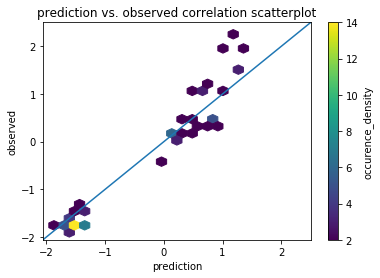

In [18]:
#Plot with trained cases. When predictions are calculated of train_data
predictions= model2(torch.Tensor(X[:,:-1]).float())
predictions= torch.Tensor.cpu(predictions).detach().numpy().reshape(-1,)
observed= X[:,-1]


hexbin_plot(predictions,observed, 'prediction' ,'observed')

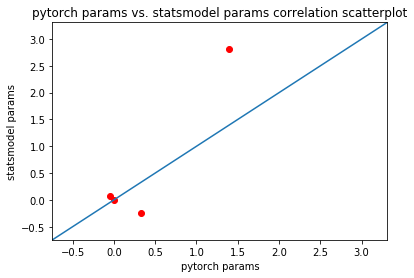

In [19]:
scatter_plot(comp_df['pytorch_params'].values,comp_df['statsmodel_params'].values, 'pytorch params' ,'statsmodel params')#n1,n2, 'abc','bcd')

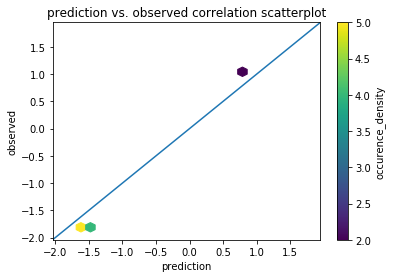

In [20]:
#Plot with unforseen cases. When predictions are calculated of test_data
predictions_2= model2(torch.Tensor(X_test[:,:-1]).float())
predictions_2= torch.Tensor.cpu(predictions_2).detach().numpy().reshape(-1,)
observed_2= X_test[:,-1]


hexbin_plot(predictions_2,observed_2, 'prediction' ,'observed')

______________________

In [ ]:
#def model():
#    class network(nn.Module):
#        def __init__(self):
#            super(network, self).__init__()
#            self.fc1 = nn.Linear(4, 100)
#            self.fc2 = nn.Linear(100, 100)
#            self.fc3 = nn.Linear(100, 3)
#            self.softmax = nn.Softmax(dim=1)
#
#        def forward(self, X):
#            X = F.relu(self.fc1(X))
#           X = self.fc2(X)
#            X = self.fc3(X)
#            X = self.softmax(X)
#            return X
#    model= network()
#    optimizer = optim.Adam(model.parameters())
#    criterion= nn.CrossEntropyLoss()
#    return model, optimizer, criterion